# Pytorch lightning tutorial

## 초기 설정

In [1]:
from torchvision import transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchsummary
import torchmetrics
import pytorch_lightning as pl

from matplotlib import pyplot as plt
import numpy as np

## 데이터 전처리

In [2]:
# 데이터 변형 함수
# Array -> Tensor로 변환 그리고 정규화

transform = transforms.Compose(
    [transforms.ToTensor(), 
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

# 데이터 로드

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainset, valset = torch.utils.data.random_split(trainset, [40000, 10000])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, 
                                        shuffle=False, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')                                

Files already downloaded and verified
Files already downloaded and verified


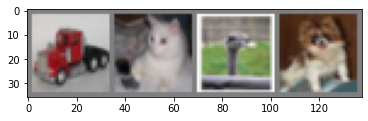

truck   cat  bird   dog


In [3]:
# 이미지 출력 함수
def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))

print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

## 모델 학습 및 평가

In [4]:
# 모델 설정

# pl.LightningModule 을 상속해야 함
# training_step과 configure_optimizers는 필수적으로 구현해야 함
# training_step -> batch, batch_idx를 받아 output과 정답 사이의 loss를 리턴
# validation_step -> batch, batch_idx를 받아 validation에서의 log를 기록
# test_step -> batch, batch_idx를 받아 test에서의 log를 기록
# configure_optimziers -> optimizer, scheduler를 구현하여 리턴
#                         만약 여러 optimizer가 필요하다면, 리스트로 리턴
class Net(pl.LightningModule):
    # 해당 모델을 처음 초기화 할 때 해당 초기화 함수 실행
    def __init__(self):
        # CNN 2개, FC 3개로 구성
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

        self.acc = torchmetrics.Accuracy()
        self.f1 = torchmetrics.F1()

    # model(x)의 형태로 모델에 입력 데이터를 넣었을 때 동작
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        output = self(x)
        loss = F.cross_entropy(output, y)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        output = self(x)
        loss = F.cross_entropy(output, y)
        acc_score = self.acc(output, y)
        f1_score = self.f1(output, y)
        self.log_dict({
            'val_acc': acc_score, 'val_f1': f1_score, 
            'val_loss': loss
        })

    def test_step(self, batch, batch_idx):
        x, y = batch 
        output = self(x)
        acc_score = self.acc(output, y)
        f1_score = self.f1(output, y)
        self.log_dict({
            'test_acc': acc_score, 'test_f1': f1_score
        })
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

In [5]:
net = Net()

torchsummary.summary(net, (3, 32, 32), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 120]          48,120
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 0.24
Estimated Total Size (MB): 0.31
----------------------------------------------------------------


In [6]:
trainer = pl.Trainer(gpus=1, max_epochs=2)
trainer.fit(net, trainloader, valloader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type      | Params
------------------------------------
0 | conv1 | Conv2d    | 456   
1 | pool  | MaxPool2d | 0     
2 | conv2 | Conv2d    | 2.4 K 
3 | fc1   | Linear    | 48.1 K
4 | fc2   | Linear    | 10.2 K
5 | fc3   | Linear    | 850   
6 | acc   | Accuracy  | 0     
7 | f1    | F1        | 0     
------------------------------------
62.0 K    Trainable params
0         Non-trainable params
62.0 K    Total params
0.248     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:112: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:112: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [7]:
trainer.test(net, testloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:112: UserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.5412999987602234, 'test_f1': 0.5412999987602234}
--------------------------------------------------------------------------------


[{'test_acc': 0.5412999987602234, 'test_f1': 0.5412999987602234}]

In [8]:
correct_pred = {class_name: 0 for class_name in classes}
total_pred = {class_name: 0 for class_name in classes}

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)

        for label, prediction in zip(labels, predicted):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

Accuracy for class plane is: 53.6 %
Accuracy for class car   is: 66.0 %
Accuracy for class bird  is: 36.3 %
Accuracy for class cat   is: 45.1 %
Accuracy for class deer  is: 37.0 %
Accuracy for class dog   is: 26.9 %
Accuracy for class frog  is: 78.4 %
Accuracy for class horse is: 64.7 %
Accuracy for class ship  is: 72.1 %
Accuracy for class truck is: 61.2 %
